In [ ]:
##Test

In [1]:
#Import Libraries
import requests
import json
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

In [32]:
#Pull factors and BTC price from Glassnode Api
API_KEY = "1rwUpyBLJnEo1qGTFlLuz1CgeTx"
vol = requests.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_sum',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
vol_df = pd.read_json(vol.text, convert_dates=['t'])

dorm = requests.get('https://api.glassnode.com/v1/metrics/indicators/average_dormancy',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
dormancy_df = pd.read_json(dorm.text, convert_dates=['t'])

# make API request
asopr = requests.get('https://api.glassnode.com/v1/metrics/indicators/sopr_adjusted',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
asopr_df = pd.read_json(asopr.text, convert_dates=['t'])
asopr_df.head()

# make API request
price_res = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_close',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
price_df = pd.read_json(price_res.text, convert_dates=['t'])

# make API request
exch_flow = requests.get('https://api.glassnode.com/v1/metrics/transactions/transfers_volume_exchanges_net',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
exch_df = pd.read_json(exch_flow.text, convert_dates=['t'])

# make API request
cdd = requests.get('https://api.glassnode.com/v1/metrics/indicators/cdd',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
cdd_df = pd.read_json(cdd.text, convert_dates=['t'])

# make API request
profit_relative = requests.get('https://api.glassnode.com/v1/metrics/supply/profit_relative',
    params={'a': 'BTC', 'api_key': API_KEY})

# convert to pandas dataframe
profit_relative_df = pd.read_json(profit_relative.text, convert_dates=['t'])


#convert to OHLCpandas dataframe
ohlc = requests.get('https://api.glassnode.com/v1/metrics/market/price_usd_ohlc',
                    params={'a': 'BTC', 'api_key': API_KEY})
j = ohlc.json()
ohlc_array=[]
for t in j:
    newdict={}
    newdict['t']=t['t']
    newdict['o']=t['o']['o']
    newdict['h']=t['o']['h']
    newdict['l']=t['o']['l']
    newdict['c']=t['o']['c']
    ohlc_array.append(newdict)
ohlc_df = pd.DataFrame(ohlc_array)
result = ohlc_df.to_json(orient="records")
ohlc_df = pd.read_json(result, convert_dates=['t'])



In [33]:
ohlc_df.rename(columns = {'t':'date', 'o':'open', 'h':'high', 'l':'low', 'c':'close'}, inplace=True)
ohlc_df.set_index('date', inplace=True)

In [34]:
vol_df.rename(columns = {'t':'date', 'v':'vol'}, inplace=True)
vol_df.set_index('date', inplace=True)


In [35]:
dormancy_df.rename(columns = {'t':'date', 'v':'dormancy'}, inplace=True)
dormancy_df.set_index('date', inplace=True)


In [36]:
asopr_df.rename(columns = {'t':'date', 'v':'asopr'}, inplace=True)
asopr_df.set_index('date', inplace=True)

In [37]:
price_df.rename(columns = {'t':'date', 'v':'price'}, inplace=True)
price_df.set_index('date', inplace=True)

In [38]:
exch_df.rename(columns = {'t':'date', 'v':'flow'}, inplace=True)
exch_df.set_index('date', inplace=True)

In [39]:
cdd_df.rename(columns = {'t':'date', 'v':'cdd'}, inplace=True)
cdd_df.set_index('date', inplace=True)

In [40]:
profit_relative_df.rename(columns = {'t':'date', 'v':'profit_relative_df'}, inplace=True)
profit_relative_df.set_index('date', inplace=True)

In [41]:
dataset = pd.concat([vol_df, dormancy_df, asopr_df, price_df, exch_df, cdd_df], axis=1, join='inner')

In [42]:
dataset.dropna(inplace=True)

In [43]:
dataset.shape

(3556, 6)

In [44]:
data_new = dataset['2015-01-01':]
data_new

,vol,dormancy,asopr,price,flow,cdd
date,,,,,,
2015-01-01,4.646205e+05,2.302504,0.987951,314.025456,124.391488,9.468414e+05
2015-01-02,7.280903e+05,2.879840,0.978582,315.687161,790.763344,1.942400e+06
2015-01-03,8.367299e+05,6.160422,0.923681,283.006535,4634.540821,4.768928e+06
2015-01-04,1.129690e+06,6.023914,0.915979,263.807883,-897.057854,5.944678e+06
2015-01-05,1.134569e+06,4.854263,0.901450,276.800000,7898.518534,5.045935e+06
...,...,...,...,...,...,...
2021-05-07,1.939428e+06,32.867983,1.105494,57369.557999,-9522.714410,2.461146e+07
2021-05-08,1.376119e+06,15.760862,1.043171,58766.584875,4655.226832,6.680947e+06
2021-05-09,1.085785e+06,22.308682,1.040930,58218.566077,7768.951037,9.067803e+06


In [45]:
dataset

,vol,dormancy,asopr,price,flow,cdd
date,,,,,,
2011-08-17,3.230502e+05,2.860031,1.023796,10.993067,0.007500,9.222607e+05
2011-08-18,4.002768e+05,3.039587,1.018691,10.847018,8.049029,1.214820e+06
2011-08-19,5.561058e+05,1.548021,1.009232,11.650000,39.591418,8.595439e+05
2011-08-20,2.246163e+05,3.934542,1.026221,11.450998,-8.048029,8.800028e+05
2011-08-21,2.428926e+05,1.686685,0.993798,11.323212,1.819000,4.080212e+05
...,...,...,...,...,...,...
2021-05-07,1.939428e+06,32.867983,1.105494,57369.557999,-9522.714410,2.461146e+07
2021-05-08,1.376119e+06,15.760862,1.043171,58766.584875,4655.226832,6.680947e+06
2021-05-09,1.085785e+06,22.308682,1.040930,58218.566077,7768.951037,9.067803e+06


In [46]:
# dataset['diff'] = dataset['price'].pct_change()
# dataset.drop(columns='price', inplace=True)
# dataset.dropna(inplace=True)
# dataset

In [47]:
def window_data(df, window, target_column):
    Xdf = df
    ydf = df[target_column]
    X, y = [], []
    for i in range(len(Xdf)-window):
        features = Xdf[i:i+window]
        X.append(features)
    for i in range(len(ydf)-window):
        target = ydf[i+window]
        y.append(target)
    return np.array(X), np.array(y).reshape(-1,1)
    
    
    

In [48]:
X, y = window_data(data_new, 20, "price")

In [49]:
split = int(0.8 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [50]:
scalers = {}
for i in range(X_train.shape[1]):
    scalers[i] = MinMaxScaler()
    X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 
for i in range(X_test.shape[1]):
    X_test[:, i, :] = scalers[i].transform(X_test[:, i, :])

In [51]:
X_test.shape

(461, 20, 6)

In [52]:
sc = MinMaxScaler()
sc.fit(y)
y_train = sc.transform(y_train)
y_test = sc.transform(y_test)

In [80]:
#GRU model
model = Sequential()
epochs = 10
model.add(GRU(100, return_sequences=True, input_shape=(X_train.shape[1],6)))
model.add(Dropout(0.2))
model.add(GRU(64))
model.add(Dropout(0.1))
model.add(Dense(32))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")
fit = model.fit(X_train, y_train, batch_size=1, epochs = epochs, validation_split=.1)

Epoch 1/10
1657/1657 [==============================] - 12s 6ms/step - loss: 0.0023 - val_loss: 1.4108e-04
Epoch 2/10
1657/1657 [==============================] - 10s 6ms/step - loss: 4.3556e-04 - val_loss: 0.0011
Epoch 3/10
1657/1657 [==============================] - 9s 6ms/step - loss: 4.3284e-04 - val_loss: 3.8406e-05
Epoch 4/10
1657/1657 [==============================] - 9s 6ms/step - loss: 2.6095e-04 - val_loss: 2.3899e-05
Epoch 5/10
1657/1657 [==============================] - 10s 6ms/step - loss: 2.1402e-04 - val_loss: 6.3873e-05
Epoch 6/10
1657/1657 [==============================] - 10s 6ms/step - loss: 1.9361e-04 - val_loss: 4.0401e-05
Epoch 7/10
1657/1657 [==============================] - 9s 6ms/step - loss: 1.5532e-04 - val_loss: 1.0903e-04
Epoch 8/10
1657/1657 [==============================] - 9s 6ms/step - loss: 1.9418e-04 - val_loss: 7.7913e-04
Epoch 9/10
1657/1657 [==============================] - 9s 6ms/step - loss: 1.6625e-04 - val_loss: 4.9125e-04
Epoch 10/10
16

In [81]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_6 (GRU)                  (None, 20, 100)           32400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 100)           0         
_________________________________________________________________
gru_7 (GRU)                  (None, 64)                31872     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

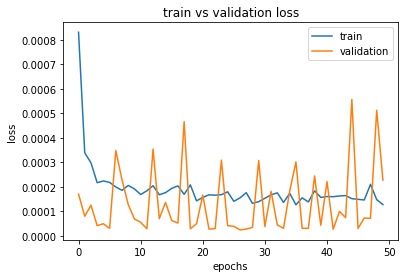

In [55]:
#Plot train vs validation loss
plt.plot(fit.history['loss'])
plt.plot(fit.history['val_loss'])
plt.title('train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [82]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 1s 4ms/step - loss: 0.0063


0.006317760329693556

In [83]:
predicted = model.predict(X_test)
predicted.shape

(461, 1)

In [84]:
mse = mean_squared_error(y_test, predicted)
mse

0.006317760260648394

In [85]:
np.sqrt(mse)

0.07948433971952207

In [86]:
predicted_close = sc.inverse_transform(predicted)
actual_close = sc.inverse_transform(y_test.reshape(-1, 1))

<AxesSubplot:xlabel='date'>

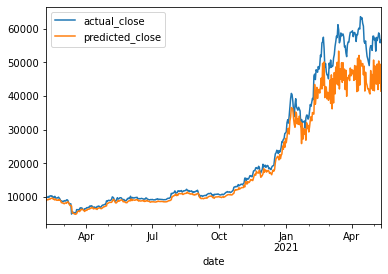

In [87]:
results_df = pd.DataFrame({
    'actual_close': actual_close.ravel(),
    "predicted_close": predicted_close.ravel()
    }, index = data_new.index[-len(real_prices): ])
results_df.plot()

In [88]:
results_prices_df = pd.concat([ohlc_df, results_df], axis=1, join='inner')
results_prices_df['predicted_perc_change'] = results_prices_df['predicted_close'].pct_change()
results_prices_df.dropna(inplace=True)
results_prices_df.reset_index(inplace=True)
results_prices_df.tail()

,date,open,high,low,close,actual_close,predicted_close,predicted_perc_change
455,2021-05-07,56413.953551,58516.499418,55404.680358,57369.557999,57369.557999,41913.179688,-0.153398
456,2021-05-08,57352.765953,59454.684237,57061.019638,58766.584875,58766.584875,50413.832031,0.202816
457,2021-05-09,58949.175691,59210.881789,56594.240801,58218.566077,58218.566077,43755.273438,-0.132078
458,2021-05-10,58313.694230,59463.950585,54558.287582,55824.861667,55824.861667,49449.738281,0.130144
459,2021-05-11,55828.260785,56870.394152,54696.374470,56714.088910,56714.088910,41431.125000,-0.162157


In [89]:
position=0
realized_profit = 0
unrealized_profit = 0 
profitable_transactions=0
unprofitable_transactions=0
data_size = len(results_prices_df.index)

for index, value in results_prices_df.iterrows():
    if index<data_size-1:
        open_price = results_prices_df.iloc[index][1]
        close_price = results_prices_df.iloc[index][4]
        tmo_open_price = results_prices_df.iloc[index+1][1]
        tmo_close_price = results_prices_df.iloc[index+1][4]
        
        if position == 1:
            unrealized_profit = close_price - buy_price
        if value[7] > 0:
            if position == 0:
                buy_price = tmo_open_price
                position = 1
        if value[7] < 0:
            if position ==1:
                sell_price = tmo_open_price
                position = 0
                trans_profit = sell_price-buy_price
                unrealized_profit = 0 
                realized_profit += trans_profit
                if trans_profit>=0:
                    profitable_transactions+=1
                else:
                    unprofitable_transactions+=1

            
            
            
print(realized_profit)
print(unrealized_profit)
print(profitable_transactions)
print(unprofitable_transactions)

28090.235559594388
0
88
58
